In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from elementtree.ElementTree import Element, ElementTree, SubElement, dump, parse, tostring  
import collections
import math
from nltk import cluster
import numpy as np
import random
import matplotlib.axes as ax
import networkx as nx
import scipy as sp
import statistics as st
import matplotlib.pyplot as plt
import csv
import re
from itertools import groupby
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering, KMeans
from sklearn import metrics
from sklearn import preprocessing

import time
import SNF
import displayClusters
import affinityMatrix
import gc
from matplotlib.pyplot import imshow
from numpy import linalg as la
import sys

In [2]:
path = "../Div400/devset/devsetkeywords/"
#path = "../Div400/testset/testset_keywordsGPS/"

# read topic file
topicpath = path+"devsetkeywords_topics.xml"
topicXML = open(topicpath, 'r')
tree = parse(topicXML)
root = tree.getroot()

topics = []
for element in root.findall('topic'):
    topics.append(element.findtext('title'))

print topics
print len(topics)

['Abbey of Saint Gall', 'Basilica of Saint Peter Vatican', 'Basilica of St Mary of Health Venice', 'Campo Santo Pisa', 'Canadian National Vimy Memorial France', 'Casas Grandes Chihuahua Mexico', 'El Infiernito Boyaca Colombia', 'Fort Stanwix New York', 'George Washington Birthplace Virginia', 'Hosios Loukas Monastery Greece', 'Kaiser Wilhelm Denkmal', 'Leaning Tower of Pisa', 'Liberty Hall Georgia', 'Louvre piramid Paris', 'Monastery of Batalha', 'National Museum of Art of Romania', 'Philopappos Monument', 'Quinta Vergara Vina del Mar Chile', 'Royal Palace of Caserta', 'Tottenham High Cross', 'Trento Cathedral', 'Tuskegee University', 'Villa della Regina Turin', 'Wupatki National Monument Arizona', 'Wurzburg Residence Germany']
25


In [3]:
def get_textdescs_all(path, topics):
    desc = collections.defaultdict(list)
    txtdesc_path = path + "desctxt/devsetkeywords-social-tfidf.txt" # social tf-idf weighting
    with open(txtdesc_path, 'r') as text:
        for line in text:
            for topic in topics:
                if line.startswith(topic):
                    descs = line.lstrip(topic).split()
                    desc.update(zip(descs, descs[1:])[::2])
                    break
    #print topics[0]
    #print desc
    
    return desc

def get_textdescs_query(path, topic):
    desc = collections.defaultdict(list)
    txtdesc_path = path + "desctxt/devsetkeywords-social-tfidf.txt" # social tf-idf weighting
    with open(txtdesc_path, 'r') as text:
        for line in text:
            if line.startswith(topic):
                descs = line.lstrip(topic).split()
                desc.update(zip(descs, descs[1:])[::2])
                break
    #print topics[0]
    #print desc
    
    return desc

In [4]:
def get_tags_all(path, topics):
    vec = []
    nodes = []
    tagdict = {}
    for topic in topics:
        targetpath = path+"xml/"+topic+".xml"
        targetXML = open(targetpath, 'r')
        tree = parse(targetXML)
        root = tree.getroot()
       
        #print topic
        for neighbor in root.getiterator('photo'):
            #rank = neighbor.attrib.get('rank')
            photoid = neighbor.attrib.get('id') ## -------> add node with phto id
            tags = neighbor.attrib.get('tags')
            tagvec = tags.split()
            #if not len(tagvec) == 0:
            #vec.append(tagvec)
            tagdict[photoid] = tagvec
            nodes.append(photoid)
    
    #tagdict = dict(zip(nodes, vec))
    #print len(tagdict), len(nodes)
    #return vec, nodes
    
    return tagdict, nodes

def get_tags_query(path, topic):
    vec = []
    nodes = []
    targetpath = path+"xml/"+topic+".xml"
    targetXML = open(targetpath, 'r')
    tree = parse(targetXML)
    root = tree.getroot()
    
    

    #print topic
    for neighbor in root.getiterator('photo'):
        #rank = neighbor.attrib.get('rank')
        photoid = neighbor.attrib.get('id') ## -------> add node with phto id
        tags = neighbor.attrib.get('tags')
        tagvec = tags.split()
        #if not len(tagvec) == 0:
        vec.append(tagvec)
        nodes.append(photoid)
    
    tagdict = dict(zip(nodes, vec))
    #print vec
    #return vec, nodes
    return tagdict, nodes


In [5]:
def viterbi_segment(text):
    probs, lasts = [1.0], [0]
    for i in range(1, len(text) + 1):
        prob_k, k = max((probs[j] * word_prob(text[j:i]), j)
                        for j in range(max(0, i - max_word_length), i))
        probs.append(prob_k)
        lasts.append(k)
    words = []
    i = len(text)
    while 0 < i:
        words.append(text[lasts[i]:i])
        i = lasts[i]
    words.reverse()
    #return words, probs[-1]
    return words

def word_prob(word): return dictionary.get(word, 0) / total
def words(text): return re.findall('[a-z]+', text.lower()) 

dictionary = dict((w, len(list(ws))) for w, ws in groupby(sorted(words(open('big.txt').read()))))
max_word_length = max(map(len, dictionary))
total = float(sum(dictionary.values()))

In [6]:
#def magnitude(v):
#    return math.sqrt(sum(v[i]*v[i] for i in range(len(v))))

def normalize(v):
    vmean = st.mean(v)
    return [v[i]-vmean for i in range(len(v))]
    #vmag = magnitude(v)
    #if vmag == 0:
    #    return [0 for i in range(len(v))]
    #else:
    #    return [ v[i]/vmag  for i in range(len(v)) ]

def tags2descs(tagset, txtdict):
    vec = []
    for tag in tagset:
        if tag in txtdict:
            vec.append(np.float64(txtdict[tag]))
        else:
            vec.append(0)
    
    return vec
    
#def ind_intersection(set1, set2):
#    ind = [i for (i,x) in enumerate(set1) if x in set(set1).intersection(set2)]
#    return ind

def viterbi_intersection(A,B,vA,vB):
    inter = []
    for i in np.arange(len(vA)):
        for j in np.arange(len(vB)):
            if len(list(set(vA[i]) & set(vB[j]))) > 0:
                inter.append(A[i])
                inter.append(B[j])

    return list(set(inter)) 



def tag_similarity(pid1, pid2, tagdict, txtdict, distance):
    
    set1 = tagdict[pid1]
    set2 = tagdict[pid2]
    
    vset1 = viterbi_segmented_tagdict[pid1]
    vset2 = viterbi_segmented_tagdict[pid2]
    
    # convert tags to descriptor values 
    vec1 = tags2descs(set1, txtdict)
    vec2 = tags2descs(set2, txtdict)

    #print vec1, vec2
    if distance == 'wpearson':
        # normalize tag vector for each image
        vec1 = normalize(vec1)
        vec2 = normalize(vec2)
        #print vec1, vec2
        # intersection of tag vector of two images
        dict1 = dict(zip(set1, vec1))
        dict2 = dict(zip(set2, vec2))
        
        v1 = [dict1[k] for k in list(set(set1) & set(set2))]
        v2 = [dict2[k] for k in list(set(set1) & set(set2))]
        
        #v1 = [dict1[k] for k in inter_list]
        #v2 = [dict2[k] for k in inter_list]
        
        if not v1 and not v2:
            return 0
        else:
            return 1-cluster.util.cosine_distance(v1, v2)
        
        #return v1, v2
        
    elif distance == 'wjaccard':
        
        intersect = tags2descs( list(set(set1) & set(set2)), txtdict )
        union = tags2descs( list(set(set1) | set(set2)), txtdict )
        #print list(set(set1) | set(set2))
        #print intersect, union
        
        if sum(union)==0:
            return 0
        else:
            return sum(intersect)/sum(union)
        
    elif distance == 'wjaccard_vit':
        inter_list = viterbi_intersection(set1, set2, vset1, vset2)
        #print inter_list
        intersect = tags2descs( inter_list, txtdict )
        union = tags2descs( list(set(set1) | set(set2)), txtdict )
        
        
        if sum(union)==0:
            return 0
        else:
            return sum(intersect)/sum(union)
        
def tag_descriptor(pid1, pid2, tagdict, nodes, txtdict, distance):
    
    nodelen = len(nodes)
    
    for n in xrange(0, nodelen):
        set = tagdict[nodes[n]]
        vset = viterbi_segmented_tagdict[nodes[n]]
    
    # convert tags to descriptor values 
    vec = tags2descs(set, txtdict)

    #print vec1, vec2
    if distance == 'wpearson':
        # normalize tag vector for each image
        vec1 = normalize(vec1)
        vec2 = normalize(vec2)
        #print vec1, vec2
        # intersection of tag vector of two images
        dict1 = dict(zip(set1, vec1))
        dict2 = dict(zip(set2, vec2))
        
        v1 = [dict1[k] for k in list(set(set1) & set(set2))]
        v2 = [dict2[k] for k in list(set(set1) & set(set2))]
        
        #v1 = [dict1[k] for k in inter_list]
        #v2 = [dict2[k] for k in inter_list]
        
        if not v1 and not v2:
            return 0
        else:
            return 1-cluster.util.cosine_distance(v1, v2)
        
        #return v1, v2
        
    elif distance == 'wjaccard':
        
        intersect = tags2descs( list(set(set1) & set(set2)), txtdict )
        union = tags2descs( list(set(set1) | set(set2)), txtdict )
        #print list(set(set1) | set(set2))
        #print intersect, union
        
        if sum(union)==0:
            return 0
        else:
            return sum(intersect)/sum(union)
        
    elif distance == 'wjaccard_vit':
        inter_list = viterbi_intersection(set1, set2, vset1, vset2)
        #print inter_list
        intersect = tags2descs( inter_list, txtdict )
        union = tags2descs( list(set(set1) | set(set2)), txtdict )
        
        
        if sum(union)==0:
            return 0
        else:
            return sum(intersect)/sum(union)
    

In [8]:
f = open('pid_location_dict.txt', 'w')

for topic in topics:
    targetpath = path+"xml/"+topic+".xml"
    targetXML = open(targetpath, 'r')
    tree = parse(targetXML)
    root = tree.getroot()
   
    for neighbor in root.getiterator('photo'):
        photoid = neighbor.attrib.get('id') ## -------> add node with phto id
        f.write("%s,%s\n" % (photoid, topic))

f.close()

In [7]:
# get all tag lists for topics
topi = 0
#tagdict, nodes = get_tags_query(path, topics[topi])
tagdict, nodes = get_tags_all(path, topics)

In [16]:
print tagdict['78572461']

['triptoitaly', 'rome', 'italy', 'basilicasanpietro', 'saintpeterscathedral', 'night', 'fountain']


In [8]:
#a = dict(collections.Counter(tagdict))

#txtdict = get_textdescs_query(path, topics[topi])
txtdict = get_textdescs_all(path, topics)

#print len(tags)
#print tags
#print txtdict
#print len(txtdict)

#print tags[0]
#print nodes[0]
#print len(tags), len(nodes)
print len(tagdict), len(nodes)

#print tags[2], tags[3]
#print tag_similarity(tags[2], tags[3], txtdict, 'wpearson'), tag_similarity(tags[2], tags[3], txtdict, 'wjaccard_vit')
#start=time.time()
#print viterbi_segment('nationalismirish')
#print time.time()-start

#print tagdict[nodes[0]], tagdict[nodes[1]]
#print tag_similarity(nodes[0], nodes[0], tagdict, txtdict, 'wpearson'), tag_similarity(nodes[0], nodes[2], tagdict, txtdict, 'wjaccard'), tag_similarity(nodes[0], nodes[1], tagdict, txtdict, 'wjaccard_vit')
#start=time.time()
#a=tag_similarity(nodes[0], nodes[0], tagdict, txtdict, 'wjaccard_vit')
#print time.time()-start


viterbi_segmented_tagdict = {}
for i in np.arange(len(nodes)):
    N = nodes[i]
    viterbi_segmented_tagdict[N]=[]
    for tag in tagdict[N]: viterbi_segmented_tagdict[N].append(viterbi_segment(tag))
print viterbi_segmented_tagdict

{'4192151327': ['chihuahua', 'mexico', 'pottery', 'paquime', 'olla', 'mata', 'ortiz', 'casas', 'grandes', 'art', 'arte'], '3750868472': ['dsc5773', 'bath', 'bagno', 'trento', 'nikond40x', 'fontanadelnettuno', 'laurea', 'piazzaduomo', 'fuentesfountains', 'neptune', 'pope', 'papa', 'cattedraledisanvigilio', 'duomoditrento', 'illegal', 'italians', 'trent', 'trentino', 'italia', 'italy'], '4057279960': ['portugal', 'europe', 'october', '2009', 'honeymoon', 'byjennypearce', 'monasteryofbatalha', 'monasteryofthedominicansofbatalha', 'aljubarrota', 'gothic', 'manueline', 'royalcloister', 'batalha', 'leiria', 'monastery', 'unesco', 'worldheritage'], '482561217': ['canadian', 'war', 'ww1', 'memorial', 'vimy', 'france', 'sculpture'], '2806044371': ['brooklynmuseum', 'catherald', 'ferrara', 'italia', 'italy', 'duomo', 'romanic', 'gothic', 'piazzatrentotrieste', 'piazza', 'emiliaromagna', 'emilia', 'geo:suggestedby=68704064n03'], '7244309706': ['brunswick', 'georgia'], '856726934': ['turin', 'piem

In [9]:
#print tags
#print len(txtdict)
#print tagdict[nodes[0]]
#print tags2descs(tagdict[nodes[0]], txtdict)

print txtdict

defaultdict(<type 'list'>, {'wupatkinationalmonument': '4.59044553618421', 'uspresidents': '1.09969356106019', 'parroquias': '0.258751426131811', 'augustine': '0.692431493807509', 'memorialhouse': '1.09969356106019', 'analogphotography': '0.132859037834781', 'cambroncino': '0.258751426131811', 'guacamayas': '0.733129040706797', 'yellow': '1.04844008539843', 'four': '0.629117141394712', 'triptoitaly': '0.14422210636855', '4020': '0.17250095075454', 'ornate': '0.10647480976209', 'escrituras': '0.258751426131811', 'd\xc3\xada': '0.308802255306736', 'pedro': '0.177204699007111', 'paris': '2.00581635244763', 'decadentes': '0.366564520353398', 'victorseymourallward': '0.488752693804531', 'swan': '2.7406553357705', 'disability': '1.75950969769631', 'ciumestihelmet': '0.439877424424078', 'outdooradvertising': '1.75950969769631', 'pantocrator': '1.15777161541737', 'bike': '1.10034232449545', 'maconcountyal': '1.09969356106019', 'fuente': '0.174333520737917', 'rhinelandpalatinaterheinlandpfalzrh

In [9]:
def make_graph(tagdict, txtdict, nodes, distm, thres, fname):
    
    #path = 'tag_network_'+distm+'_'+thres+'.graphml'
    f = open(fname, 'w')
    
    #G=nx.Graph()
    
    #random.seed(1)
    #tags_half = random.sample(tags, len(tags)/2)
    nodelen = len(nodes)
    adj = np.zeros(shape=(nodelen, nodelen), dtype=np.float64)
    
    #G.add_nodes_from(nodes)
    start = time.time()
    for r in xrange(0, nodelen):
        for c in xrange(0, nodelen):
            sim = tag_similarity(nodes[r], nodes[c], tagdict, txtdict, distm)
            #print type(sim), r,c
            adj[r][c] = sim
            
            f.write("%s %s %f\n" % (nodes[r], nodes[c], sim))
            
            #if sim > float(thres) and math.isnan(sim) == False:
            #G.add_edge(nodes[r], nodes[c], weight="%.4f"%sim)
            
    print time.time()-start
    #adj = preprocessing.normalize(adj, norm='l2')
    #adj = preprocessing.MinMaxScaler().fit_transform(adj)
    
    f.close()
    
    return adj
    #return G, adj
    #nx.write_graphml(G, path)
    #print "write network complete"
    

In [10]:
print list(set(np.arange(1,26))-set([13,20,22]))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 21, 23, 24, 25]


In [10]:
ind = 0
photoid = []
# photoid_sub10 = []
photoid_sub20 = []
# photoid_cl10 = []
# photoid_cl5 = []
# photoid_cl3 = []

clusterid = []

gt = {}

up20_group = list(set(np.arange(1,len(topics)+1))-set([13,20,22]))
cl10 = np.random.choice(up20_group, 10, replace=False)
cl5 = np.random.choice(up20_group, 5, replace=False)
cl3 = np.random.choice(up20_group, 3, replace=False)

print cl10, cl5, cl3

for topic in topics:
    ind = ind+1
    truepath = path+"gt/dGT/"+topic+" dGT.txt"
    #truepath = path+"gt/dGT/"+topics[topi]+" dGT.txt"
    
    f = open(truepath)
    line = f.readline().strip()
    
    tmp = []
    while line: 
        columns = line.split(',')
        photoid.append(columns[0])
        tmp.append(columns[0])
        
        #clusterid.append(columns[1])
        clusterid.append(ind)
        
        #gt[columns[0]] = int(columns[1])
        gt[columns[0]] = ind
        line = f.readline().strip()
    
    print len(tmp)
    if len(tmp) >= 10: photoid_sub10.extend(np.random.choice(tmp, 10, replace=False))
    if len(tmp) >= 20: 
        sub20 = np.random.choice(tmp, 20, replace=False)
        photoid_sub20.extend(sub20)
        if ind in cl10: photoid_cl10.extend(sub20)
        if ind in cl5: photoid_cl5.extend(sub20)
        if ind in cl3: photoid_cl3.extend(sub20)   
    
    
    #print gt
    #print topics[0]

print len(photoid_sub10), len(photoid_sub20), len(photoid_cl10), len(photoid_cl5), len(photoid_cl3)


inters = list(set(nodes) & set(photoid))
inters_sub10 = list(set(nodes) & set(photoid_sub10))
inters_sub20 = list(set(nodes) & set(photoid_sub20))
inters_cl10 = list(set(nodes) & set(photoid_cl10))
inters_cl5 = list(set(nodes) & set(photoid_cl5))
inters_cl3 = list(set(nodes) & set(photoid_cl3))

#print nodes
#print photoid
#print inters
print len(nodes), len(inters)


trues = np.empty(len(inters_sub20))
for i in range(len(inters_sub20)):
    trues[i] = gt[inters_sub20[i]]    
np.savetxt('trues_sub20.txt', trues, fmt='%d', newline=' ')
np.savetxt('inters_sub20.txt', inters_sub20, fmt='%s', newline=' ')

[11  2 21  1 12 16 24 23  5 19] [ 3  7  6 12 18] [ 1 10  3]
57
129
39
98
64
20
22
26
108
70
107
128
15
52
141
31
34
28
142
5
44
3
28
124
43
230 440 200 100 60
2281 1558


In [12]:
inters_sub20 = np.loadtxt('inters_sub20.txt')


array([  4.19215133e+09,   5.40023511e+09,   5.92305159e+09,
         2.78213012e+09,   8.56726934e+08,   4.27356503e+09,
         4.85320318e+09,   7.25939761e+09,   5.64629548e+09,
         2.47121845e+09,   8.69573258e+08,   4.04780370e+09,
         3.06419067e+09,   8.33025886e+09,   3.66441774e+09,
         5.06516748e+09,   4.82536071e+09,   4.82561217e+08,
         4.13445526e+09,   4.10697942e+09,   3.81197885e+09,
         5.60081907e+09,   5.98195342e+09,   2.47447526e+09,
         6.19023828e+09,   3.07126872e+09,   3.41248798e+09,
         2.80616713e+09,   5.96209418e+09,   7.25939737e+09,
         2.47116390e+09,   3.08496202e+08,   3.07126913e+09,
         4.92600592e+09,   3.66442013e+09,   3.07210685e+09,
         1.95095305e+08,   5.04540406e+09,   5.96088306e+09,
         3.37401210e+07,   4.05728744e+09,   3.66080487e+09,
         2.80690614e+09,   4.82560965e+08,   2.78212985e+09,
         4.97918824e+08,   5.11452929e+09,   4.05726404e+09,
         3.07210358e+09,

In [26]:
adj_pson = make_graph(tagdict, txtdict, inters_sub20, 'wpearson', '0')
np.save('adj_socialtfidf_pearson_sub20', np.nan_to_num(adj_pson))
np.savetxt('adj_socialtfidf_pearson_sub20.txt', np.nan_to_num(adj_pson))
adj = make_graph(tagdict, txtdict, inters_sub20, 'wjaccard', '0')
np.save('adj_socialtfidf_jaccard_sub20', np.nan_to_num(adj))
np.savetxt('adj_socialtfidf_jaccard_sub20.txt', np.nan_to_num(adj))
adj_vit = make_graph(tagdict, txtdict, inters_sub20, 'wjaccard_vit', '0')
np.save('adj_socialtfidf_jaccardvit_sub20', np.nan_to_num(adj_vit))
np.savetxt('adj_socialtfidf_jaccardvit_sub20.txt', np.nan_to_num(adj_vit))



adj_pson = make_graph(tagdict, txtdict, inters_sub10, 'wpearson', '0')
np.save('adj_socialtfidf_pearson_sub10', np.nan_to_num(adj_pson))
np.savetxt('adj_socialtfidf_pearson_sub10.txt', np.nan_to_num(adj_pson))
adj = make_graph(tagdict, txtdict, inters_sub10, 'wjaccard', '0')
np.save('adj_socialtfidf_jaccard_sub10', np.nan_to_num(adj))
np.savetxt('adj_socialtfidf_jaccard_sub10.txt', np.nan_to_num(adj))
adj_vit = make_graph(tagdict, txtdict, inters_sub10, 'wjaccard_vit', '0')
np.save('adj_socialtfidf_jaccardvit_sub10', np.nan_to_num(adj_vit))
np.savetxt('adj_socialtfidf_jaccardvit_sub10.txt', np.nan_to_num(adj_vit))

trues = np.empty(len(inters_sub10))
for i in range(len(inters_sub10)):
    trues[i] = gt[inters_sub10[i]]    
np.savetxt('trues_sub10.txt', trues, fmt='%d', newline=' ')
np.savetxt('inters_sub10.txt', inters_sub10, fmt='%s', newline=' ')

adj_pson = make_graph(tagdict, txtdict, inters_cl10, 'wpearson', '0')
np.save('adj_socialtfidf_pearson_cl10', np.nan_to_num(adj_pson))
np.savetxt('adj_socialtfidf_pearson_cl10.txt', np.nan_to_num(adj_pson))
adj = make_graph(tagdict, txtdict, inters_cl10, 'wjaccard', '0')
np.save('adj_socialtfidf_jaccard_cl10', np.nan_to_num(adj))
np.savetxt('adj_socialtfidf_jaccard_cl10.txt', np.nan_to_num(adj))
adj_vit = make_graph(tagdict, txtdict, inters_cl10, 'wjaccard_vit', '0')
np.save('adj_socialtfidf_jaccardvit_cl10', np.nan_to_num(adj_vit))
np.savetxt('adj_socialtfidf_jaccardvit_cl10.txt', np.nan_to_num(adj_vit))

trues = np.empty(len(inters_cl10))
for i in range(len(inters_cl10)):
    trues[i] = gt[inters_cl10[i]]    
np.savetxt('trues_cl10.txt', trues, fmt='%d', newline=' ')
np.savetxt('inters_cl10.txt', inters_cl10, fmt='%s', newline=' ')

adj_pson = make_graph(tagdict, txtdict, inters_cl5, 'wpearson', '0')
np.save('adj_socialtfidf_pearson_cl5', np.nan_to_num(adj_pson))
np.savetxt('adj_socialtfidf_pearson_cl5.txt', np.nan_to_num(adj_pson))
adj = make_graph(tagdict, txtdict, inters_cl5, 'wjaccard', '0')
np.save('adj_socialtfidf_jaccard_cl5', np.nan_to_num(adj))
np.savetxt('adj_socialtfidf_jaccard_cl5.txt', np.nan_to_num(adj))
adj_vit = make_graph(tagdict, txtdict, inters_cl5, 'wjaccard_vit', '0')
np.save('adj_socialtfidf_jaccardvit_cl5', np.nan_to_num(adj_vit))
np.savetxt('adj_socialtfidf_jaccardvit_cl5.txt', np.nan_to_num(adj_vit))

trues = np.empty(len(inters_cl5))
for i in range(len(inters_cl5)):
    trues[i] = gt[inters_cl5[i]]    
np.savetxt('trues_cl5.txt', trues, fmt='%d', newline=' ')
np.savetxt('inters_cl5.txt', inters_cl5, fmt='%s', newline=' ')


adj_pson = make_graph(tagdict, txtdict, inters_cl3, 'wpearson', '0')
np.save('adj_socialtfidf_pearson_cl3', np.nan_to_num(adj_pson))
np.savetxt('adj_socialtfidf_pearson_cl3.txt', np.nan_to_num(adj_pson))
adj = make_graph(tagdict, txtdict, inters_cl3, 'wjaccard', '0')
np.save('adj_socialtfidf_jaccard_cl3', np.nan_to_num(adj))
np.savetxt('adj_socialtfidf_jaccard_cl3.txt', np.nan_to_num(adj))
adj_vit = make_graph(tagdict, txtdict, inters_cl3, 'wjaccard_vit', '0')
np.save('adj_socialtfidf_jaccardvit_cl3', np.nan_to_num(adj_vit))
np.savetxt('adj_socialtfidf_jaccardvit_cl3.txt', np.nan_to_num(adj_vit))

trues = np.empty(len(inters_cl3))
for i in range(len(inters_cl3)):
    trues[i] = gt[inters_cl3[i]]    
np.savetxt('trues_cl3.txt', trues, fmt='%d', newline=' ')
np.savetxt('inters_cl3.txt', inters_cl3, fmt='%s', newline=' ')

#adj_pson = make_graph(tagdict, txtdict, inters, 'wpearson', '0')
#np.save('adj_socialtfidf_pearson', adj_pson)
#adj = make_graph(tagdict, txtdict, inters, 'wjaccard', '0')
#np.save('adj_socialtfidf_jaccard', adj)
#adj_vit = make_graph(tagdict, txtdict, inters, 'wjaccard_vit', '0')
#np.save('adj_socialtfidf_jaccardvit', adj_vit)


#print adj[0][1]


4.02306199074
4.66070008278
19.6839940548
1.07395100594
1.23197603226
5.0694270134
0.901795148849
1.00359582901
4.78426790237
0.26264500618
0.303166866302
1.70626711845
0.0538890361786
0.0485610961914
0.138012170792


In [12]:
adj_probabilistic_jaccard = np.load('adj_probabilistic_jaccard.npy')
adj_probabilistic_jaccardvit= np.load('adj_probabilistic_jaccardvit.npy')
adj_probabilistic_pearson = np.load('adj_probabilistic_pearson.npy')

adj_tfidf_jaccard = np.load('adj_tfidf_jaccard.npy')
adj_tfidf_jaccardvit = np.load('adj_tfidf_jaccardvit.npy')
adj_tfidf_pearson = np.load('adj_tfidf_pearson.npy')

adj_socialtfidf_jaccard = np.load('adj_socialtfidf_jaccard.npy')
adj_socialtfidf_jaccardvit = np.load('adj_socialtfidf_jaccardvit.npy')
adj_socialtfidf_pearson = np.load('adj_socialtfidf_pearson.npy')

print adj_probabilistic_jaccard.shape, adj_probabilistic_jaccardvit.shape, adj_probabilistic_pearson.shape
print adj_tfidf_jaccard.shape, adj_tfidf_jaccardvit.shape, adj_tfidf_pearson.shape
print adj_socialtfidf_jaccard.shape, adj_socialtfidf_jaccardvit.shape, adj_socialtfidf_pearson.shape

(1558, 1558) (1558, 1558) (1558, 1558)
(1558, 1558) (1558, 1558) (1558, 1558)
(1558, 1558) (1558, 1558) (1558, 1558)


In [34]:
np.savetxt('adj_probabilistic_jaccard.txt', np.nan_to_num(adj_probabilistic_jaccard))
np.savetxt('adj_probabilistic_jaccardvit.txt', np.nan_to_num(adj_probabilistic_jaccardvit))
np.savetxt('adj_probabilistic_pearson.txt', np.nan_to_num(adj_probabilistic_pearson))

np.savetxt('adj_tfidf_jaccard.txt', np.nan_to_num(adj_tfidf_jaccard))
np.savetxt('adj_tfidf_jaccardvit.txt', np.nan_to_num(adj_tfidf_jaccardvit))
np.savetxt('adj_tfidf_pearson.txt', np.nan_to_num(adj_tfidf_pearson))

np.savetxt('adj_socialtfidf_jaccard.txt', np.nan_to_num(adj_socialtfidf_jaccard))
np.savetxt('adj_socialtfidf_jaccardvit.txt', np.nan_to_num(adj_socialtfidf_jaccardvit))
np.savetxt('adj_socialtfidf_pearson.txt', np.nan_to_num(adj_socialtfidf_pearson))


In [15]:
adj_socialtfidf_jaccard = preprocessing.normalize(adj_socialtfidf_jaccard, norm='l2')
adj_socialtfidf_jaccard = preprocessing.MinMaxScaler().fit_transform(adj_socialtfidf_jaccard)

adj_socialtfidf_jaccardvit = preprocessing.normalize(adj_socialtfidf_jaccardvit, norm='l2')
adj_socialtfidf_jaccardvit = preprocessing.MinMaxScaler().fit_transform(adj_socialtfidf_jaccardvit)

adj_socialtfidf_pearson=np.nan_to_num(adj_socialtfidf_pearson)
adj_socialtfidf_pearson = preprocessing.normalize(adj_socialtfidf_pearson, norm='l2')
adj_socialtfidf_pearson = preprocessing.MinMaxScaler().fit_transform(adj_socialtfidf_pearson)


#np.fill_diagonal(adj_socialtfidf_jaccard, 1)
#np.fill_diagonal(adj_socialtfidf_jaccardvit, 1)
#np.fill_diagonal(adj_socialtfidf_pearson, 1)

#print sum(np.diag(adj_socialtfidf_jaccard))
#print sum(np.diag(adj_socialtfidf_jaccardvit))
#print sum(np.diag(adj_socialtfidf_pearson))

print adj_socialtfidf_jaccard
print adj_socialtfidf_jaccardvit
print adj_socialtfidf_pearson

[[ 1.          0.          0.         ...,  0.          0.56741098  0.        ]
 [ 0.          1.          0.         ...,  0.          0.          0.00264694]
 [ 0.          0.          1.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  1.          0.          0.        ]
 [ 0.14929092  0.          0.         ...,  0.          1.          0.0400802 ]
 [ 0.          0.01833435  0.         ...,  0.          0.04183931  1.        ]]
[[ 1.          0.          0.         ...,  0.          0.93365227  0.        ]
 [ 0.          0.99460891  0.         ...,  0.          0.01632015
   0.00976707]
 [ 0.          0.          1.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  1.          0.06302183  0.        ]
 [ 0.46365719  0.085169    0.         ...,  0.06211875  0.9690142
   0.04096647]
 [ 0.          0.04676664  0.         ...,  0.          0.03758747
   0.94760454]]
[[ 0.80242293  0.46

In [18]:
# trues = np.empty(len(inters))

# for i in range(len(inters)):
#     trues[i] = gt[inters[i]]
    
# np.savetxt('trues.txt', trues, fmt='%d', newline=' ')
# np.savetxt('inters.txt', inters, fmt='%s', newline=' ')
# print type(inters)

trues = np.loadtxt('trues.txt')
print trues

inters = np.loadtxt('inters.txt', dtype='str')
print inters
#plt.hist(adj_socialtfidf_jaccard)
#plt.show()

#plt.hist(adj_socialtfidf_jaccardvit)
#plt.show()

#plt.hist(adj_socialtfidf_pearson)
#plt.show()

[  6.  15.   5. ...,  13.   6.  17.]
['4192151327' '4057279960' '482561217' ..., '3047328323' '497946503'
 '4134461082']


In [27]:
def eval_cluster(trues, X, delta, eigsol, numcl, assign, ari, ami, silh, simr):
    
    #aff = np.exp(-X ** 2 / (2. * delta ** 2))
    
#     X = np.nan_to_num(X)
#     aff = np.exp(- delta * X / np.std(X))
#     aff=X
#     np.fill_diagonal(aff, 1)
    
    
    #labels = SpectralClustering(n_clusters=numcl, assign_labels=assign, eigen_solver='amg', gamma=gamma).fit_predict(X)
    try:
        labels = spectral_clustering(aff, n_clusters=numcl, assign_labels=assign, eigen_solver=eigsol, eigen_tol=1e-4)
        #labels = KMeans(n_clusters=numcl, init='k-means++').fit_predict(X)
        #print labels
        
    except:
        print delta, simr
        print('error: ', sys.exc_info())
        
        ari.append(np.nan)
        ami.append(np.nan)
        silh.append(np.nan)
                
        return ari, ami, silh

    #preddict = dict(zip(inters, labels))

    #trues = np.empty(len(inters))
    #preds = np.empty(len(inters))

    #for i in range(len(inters)):
    #    trues[i] = gt[inters[i]]
        #preds[i] = preddict[inters[i]]
    
    preds = labels
    
    #np.savetxt("trues_im.csv", trues, delimiter=",")
    #np.savetxt("preds_im.csv", preds, delimiter=",")
    
    #print len(inters)
    #print len(trues), len(preds)

    #print inters,trues,preds
    #print len(inters)
    ari.append(metrics.adjusted_rand_score(trues, preds))
    ami.append(metrics.adjusted_mutual_info_score(trues, preds))
    silh.append(metrics.silhouette_score(X, labels))
    
    return ari, ami, silh


In [28]:
def showplot(x, xlabel, ylabel, evali, evali_vit=None, evali_pson=None):    
    #print x
    #print ari
    #print len(x), len(evali)

    print 'average(jaccard): ', np.sum(evali)/float(len(evali))
    evali_max = np.max(evali); 
    evali_maxi = x[evali.index(np.max(evali))]
    print 'maximum at delta: ', evali_maxi, ', score: ', evali_max
    
    if evali_vit is not None: 
        print 'average(jaccardvit): ', np.sum(evali_vit)/float(len(evali_vit))
        evali_vit_max = np.nanmax(evali_vit); 
        evali_vit_maxi = x[evali_vit.index(np.nanmax(evali_vit))]
        print 'maximum at delta: ', evali_vit_maxi, ', score: ', evali_vit_max
        
    if evali_pson is not None: 
        print 'average(pearson): ', np.sum(evali_pson)/float(len(evali_pson))
        evali_pson_max = np.nanmax(evali_pson); 
        evali_pson_maxi = x[evali_pson.index(np.nanmax(evali_pson))]
        print 'maximum at delta: ', evali_pson_maxi, ', score: ', evali_pson_max
    
    wid = (x[len(x)-1]-x[0])/6

    if (evali_vit is not None) and (evali_pson is not None): 
        plt.plot(x, evali, 'r--', x, evali_vit, 'b-.', x, evali_pson, 'g-.')
    else:
        plt.plot(x, evali, 'r--')
        
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.annotate(evali_max, xy=(evali_maxi, evali_max), xytext=(evali_maxi+wid, evali_max+0.02), arrowprops=dict(facecolor='red'))
    if evali_vit is not None: 
        plt.annotate(evali_vit_max, xy=(evali_vit_maxi, evali_vit_max), xytext=(evali_vit_maxi+wid, evali_vit_max+0.02), arrowprops=dict(facecolor='blue'))
    
    if evali_pson is not None: 
        plt.annotate(evali_pson_max, xy=(evali_pson_maxi, evali_pson_max), xytext=(evali_pson_maxi+wid, evali_pson_max+0.02), arrowprops=dict(facecolor='green'))
   
    plt.show()

In [14]:
########### changing delta of the affinity matrix (spectral clustering)
ari_jac, ami_jac, silh_jac =[], [], []
ari_jacvit, ami_jacvit, silh_jacvit = [], [], []
ari_pson, ami_pson, silh_pson = [], [], []

numcl = 25
delta=0
for delta in np.arange(0.01, 1, 0.02):
    ari_jac, ami_jac, silh_jac = eval_cluster(trues, adj_socialtfidf_jaccard, delta, 'amg', numcl, 'discretize', ari_jac, ami_jac, silh_jac, 'jaccard')
    ari_jacvit, ami_jacvit, silh_jacvit = eval_cluster(trues, adj_socialtfidf_jaccardvit, delta, 'amg', numcl, 'discretize', ari_jacvit, ami_jacvit, silh_jacvit, 'jaccardvit')
    ari_pson, ami_pson, silh_pson = eval_cluster(trues, adj_socialtfidf_pearson, delta, 'amg', numcl, 'discretize', ari_pson, ami_pson, silh_pson, 'pearson')
    
print ari_jac, ami_jac, silh_jac
print ari_jacvit, ami_jacvit, silh_jacvit
print ari_pson, ami_pson, silh_pson
    
x = np.arange(0.01, 1, 0.02)
xlabel = 'delta of the affinity matrix'
showplot(x, xlabel, 'Adjusted Rand index', ari_jac, ari_jacvit, ari_pson)
showplot(x, xlabel, 'Adjusted Mutual Information', ami_jac, ami_jacvit, ami_pson)
showplot(x, xlabel, 'Silhouette Coefficient', silh_jac, silh_jacvit, silh_pson)

/home/soyeon1771/anaconda2/lib/python2.7/site-packages/sklearn/manifold/spectral_embedding_.py:265: UserWarning: AMG works better for sparse matrices
  warnings.warn("AMG works better for sparse matrices")
/home/soyeon1771/anaconda2/lib/python2.7/site-packages/pyamg/aggregation/aggregation.py:214: SparseEfficiencyWarning: Implicit conversion of A to CSR
  SparseEfficiencyWarning)


0.01 jaccardvit
('error: ', (<class 'numpy.linalg.linalg.LinAlgError'>, LinAlgError('16-th leading minor not positive definite',), <traceback object at 0x7f2a7c1be758>))
0.03 jaccard
('error: ', (<class 'numpy.linalg.linalg.LinAlgError'>, LinAlgError("the leading minor of order 72 of 'b' is not positive definite. The factorization of 'b' could not be completed and no eigenvalues or eigenvectors were computed.",), <traceback object at 0x7f2a7c1bec20>))
0.03 jaccardvit
('error: ', (<class 'numpy.linalg.linalg.LinAlgError'>, LinAlgError('24-th leading minor not positive definite',), <traceback object at 0x7f2a7c1bed40>))
0.03 pearson
('error: ', (<class 'numpy.linalg.linalg.LinAlgError'>, LinAlgError("the leading minor of order 64 of 'b' is not positive definite. The factorization of 'b' could not be completed and no eigenvalues or eigenvectors were computed.",), <traceback object at 0x7f2a7c1beab8>))
0.05 jaccard
('error: ', (<class 'numpy.linalg.linalg.LinAlgError'>, LinAlgError('20-th 

ValueError: nan is not in list

In [ ]:
# changing number of clusters
ari_jac, ami_jac, silh_jac =[], [], []
ari_jacvit, ami_jacvit, silh_jacvit = [], [], []
ari_pson, ami_pson, silh_pson = [], [], []

#end = len(inters)

end=51
for numcl in range(3, end):
    if numcl % 2 != 0:
        ari_jac, ami_jac, silh_jac = eval_cluster(inters, gt, adj_socialtfidf_jaccard, 0.39, 'amg', numcl, 'discretize', ari_jac, ami_jac, silh_jac, 'jaccard')
        ari_jacvit, ami_jacvit, silh_jacvit = eval_cluster(inters, gt, adj_socialtfidf_jaccardvit, 0.39, 'amg', numcl, 'discretize', ari_jacvit, ami_jacvit, silh_jacvit, 'jaccardvit')
        ari_pson, ami_pson, silh_pson = eval_cluster(inters, gt, adj_socialtfidf_pearson, 0.39, 'amg', numcl, 'discretize', ari_pson, ami_pson, silh_pson, 'pearson')

[0.12543417025309875, 0.1949841171230275, 0.28549932583007837, 0.3400766419219423, 0.4417190187750778, 0.45731741484655064, 0.6056156987301488, 0.5810272818066551, 0.5764336591301745, 0.5758151748163475, 0.5523559984793284, nan, 0.6182436956884254, 0.6157228630117668, 0.6357538977333645, nan, 0.5415716793610913, nan, nan, nan, nan, nan, nan, nan] [0.26581748809672173, 0.39304704127282064, 0.49048286901749955, 0.55252049064288056, 0.63196333445995179, 0.64862217439546044, 0.69434458720766001, 0.73767607825278425, 0.75609165352188634, 0.78065062836994903, 0.77602712792635442, nan, 0.7940263700305904, 0.77870486743851086, 0.78368648965464638, nan, 0.7380309729970288, nan, nan, nan, nan, nan, nan, nan] [0.24515946433905422, 0.26292819776471266, 0.33382746904004229, 0.38488141436598072, 0.39285010721983632, 0.31883291855182633, 0.3423457552598233, 0.41089464985752444, 0.44525689103872346, 0.44463119659160388, 0.46138105643105431, nan, 0.47744366661712495, 0.47099456155678138, 0.460895269237

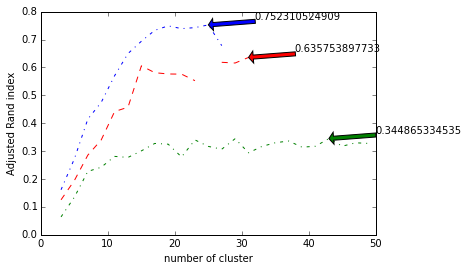

average(jaccard):  0.409237173887
maximum at delta:  27 , score:  0.794026370031
average(jaccardvit):  0.484990132828
maximum at delta:  25 , score:  0.825405525041
average(pearson):  0.529176639394
maximum at delta:  29 , score:  0.623518500664


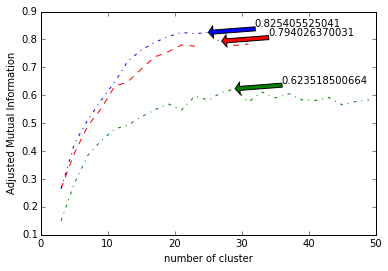

average(jaccard):  0.24655556873
maximum at delta:  27 , score:  0.477443666617
average(jaccardvit):  0.291748749772
maximum at delta:  35 , score:  0.479703015426
average(pearson):  0.261582877129
maximum at delta:  21 , score:  0.311724024306


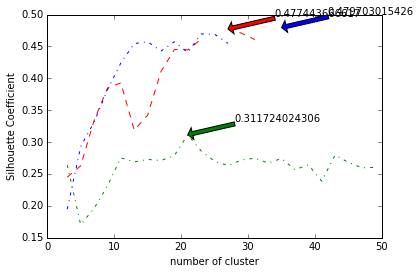

In [18]:
print ari_jac, ami_jac, silh_jac
print ari_jacvit, ami_jacvit, silh_jacvit
print ari_pson, ami_pson, silh_pson
#print ari_vit, ami_vit, silh_vit

x = [2*i+1 for i in range(1,(end-1)/2)]
xlabel = 'number of cluster'
showplot(x, xlabel, 'Adjusted Rand index', ari_jac, ari_jacvit, ari_pson)
showplot(x, xlabel, 'Adjusted Mutual Information', ami_jac, ami_jacvit, ami_pson)
showplot(x, xlabel, 'Silhouette Coefficient', silh_jac, silh_jacvit, silh_pson)

In [18]:
print x

[3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49]


In [29]:
#topic = topics[topi]
desc = "HOG"
pids = []
plist = []
for topic in topics:
    targetpath = path+"descvis/img/"+topic+" "+desc+".csv"
    with open(targetpath, 'rb') as csvfile:
        targetCSV = csv.reader(csvfile, delimiter=',')
        for row in targetCSV:
            pids.append(row[0])
            plist.append(map(float, row[1:]))
        #print len(plist)

imdict = dict(zip(pids, plist))

print len(plist)
print len(imdict)

2281
2281


In [35]:
#G_im=nx.Graph()

##############################
#inters = list(set(pids) & set(photoid))


#list_half = random.sample(list, len(list)/2)
adj_im = np.zeros(shape=(len(inters_cl3), len(inters_cl3)), dtype=np.float64)

#f = open("img_HOG_network.txt", 'w')

for r in xrange(0, len(inters_cl3)):
    for c in xrange(0, len(inters_cl3)):
        sim = sp.spatial.distance.euclidean(imdict[inters_cl3[r]], imdict[inters_cl3[c]])
        #print sim
        adj_im[r][c] = sim
        
        #f.write("%s %s %f\n" % (inters[r], inters[c], sim))
        #print tags[r], tags[c], sim
        #if sim > 0 and math.isnan(sim) == False:
        #G_im.add_edge(r, c, weight="%.4f"%sim)

#adj_im = preprocessing.normalize(adj_im, norm='l2')
#adj_im = preprocessing.MinMaxScaler().fit_transform(adj_im)
print adj_im.shape
np.savetxt('adj_HOG_euclidean_cl3.txt', np.nan_to_num(adj_im))

(60, 60)


In [ ]:
print adj_im.shape, adj.shape
print len(inters), len(gt)

x = np.asarray(adj).reshape(-1)
y = np.asarray(adj_im).reshape(-1)

fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0]*x + fit[1], color='red')
ax.scatter(x, y)
plt.xlim(0,1)
plt.ylim(0,1)
fig.show()


x = np.asarray(adj_vit).reshape(-1)

fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0]*x + fit[1], color='red')
ax.scatter(x, y)
plt.xlim(0,1)
plt.ylim(0,1)
fig.show()

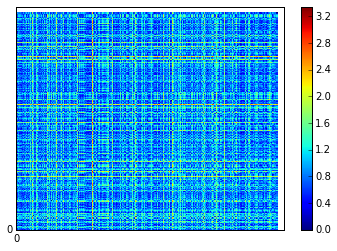

In [48]:
from pylab import pcolor, show, colorbar, xticks, yticks
pcolor(adj_im)
colorbar()
yticks(np.arange(0,1),range(0,1))
xticks(np.arange(0,1),range(0,1))
show()

In [33]:
#range(3,29)
#a=range(1,(29-1)/2)
#print [2*i+1 for i in range(1,(29-1)/2)]

r = 2
c = 3
print imdict[inters[r]], imdict[inters[c]]
print cluster.util.cosine_distance(imdict[inters[c]], imdict[inters[r]])

print adj_im[r][c], adj_im[c][r]


[0.2607130867627126, 0.26360087693081563, 0.5696314810328855, 0.20855144008095822, 0.3316366534591792, 0.25065869315915423, 0.4358149179151706, 0.2749910026930382, 0.2370699737617932, 0.29979977896251225, 0.26143370831805696, 0.5313366078568215, 0.22156354483570917, 0.3461492515694847, 0.2612700897315383, 0.40535757709622566, 0.28195021783847973, 0.28012753885300595, 0.3387777249848044, 0.2372722588495023, 0.4923550093748008, 0.2303224268439421, 0.39499676908068415, 0.2564131933522302, 0.3929553955534626, 0.27455766721994423, 0.286188054190118, 0.3258281012704003, 0.31146039297955685, 0.44772784319504394, 0.2334417596645513, 0.42389752771656675, 0.2769469416112976, 0.3572333671326375, 0.29131237100493423, 0.2701959950228364, 0.3593229146742109, 0.29552449906094275, 0.45630632058367193, 0.23347402832533984, 0.40173902155737445, 0.26704155095832605, 0.3499550250312494, 0.2825075501977331, 0.2929884745374405, 0.403793749140071, 0.2452854906260862, 0.43172561859043884, 0.21366403933925862,

In [25]:
eval_cluster(inters, gt, adj_im, 0.5, 'arpack', 25, 'discretize', [],[],[])

([0.047853720086485266], [0.1288458047306778], [-0.1777988043658407])

In [58]:
# changing number of clusters
ari, ami, silh =[], [], []

#end = 51
end = 29
for numcl in range(3, end):
    if numcl % 2 != 0:
        ari, ami, silh = eval_cluster(inters, gt, adj_im, numcl, 'discretize', 0, ari, ami, silh)

print ari, ami, silh

x = [2*i+1 for i in range(1,(end-1)/2)]
xlabel = 'number of cluster'
showplot(x, xlabel, 'Adjusted Rand index', ari)
showplot(x, xlabel, 'Adjusted Mutual Information', ami)
showplot(x, xlabel, 'Silhouette Coefficient', silh)

LinAlgError: the leading minor of order 8 of 'b' is not positive definite. The factorization of 'b' could not be completed and no eigenvalues or eigenvectors were computed.

0.01
('error: ', <type 'exceptions.NameError'>)
0.02
('error: ', <type 'exceptions.NameError'>)
0.03
('error: ', <type 'exceptions.NameError'>)
0.04
('error: ', <type 'exceptions.NameError'>)
0.05
('error: ', <type 'exceptions.NameError'>)
0.06
('error: ', <type 'exceptions.NameError'>)
0.07
('error: ', <type 'exceptions.NameError'>)
0.08
('error: ', <type 'exceptions.NameError'>)
0.09
('error: ', <type 'exceptions.NameError'>)
0.1
('error: ', <type 'exceptions.NameError'>)
0.11
('error: ', <type 'exceptions.NameError'>)
0.12
('error: ', <type 'exceptions.NameError'>)
0.13
('error: ', <type 'exceptions.NameError'>)
0.14
('error: ', <type 'exceptions.NameError'>)
0.15
('error: ', <type 'exceptions.NameError'>)
0.16
('error: ', <type 'exceptions.NameError'>)
0.17
('error: ', <type 'exceptions.NameError'>)
0.18
('error: ', <type 'exceptions.NameError'>)
0.19
('error: ', <type 'exceptions.NameError'>)
0.2
('error: ', <type 'exceptions.NameError'>)
0.21
('error: ', <type 'exceptions.NameErr

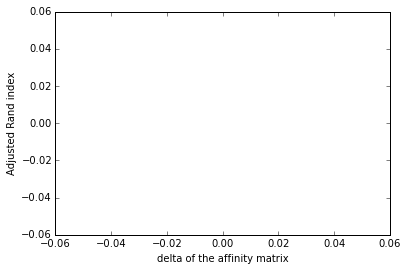

49 49
nan
0.01


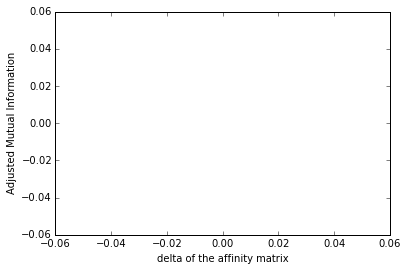

49 49
nan
0.01


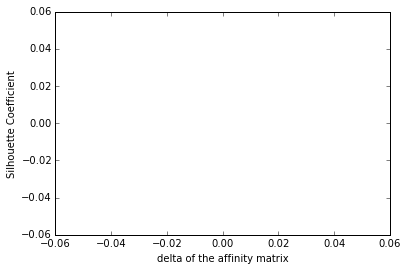

In [22]:
########### changing delta of the affinity matrix (spectral clustering)
ari, ami, silh =[], [], []
numcl = 25

for delta in np.arange(0.01, 0.5, 0.01):
    ari, ami, silh = eval_cluster(inters, gt, adj_im, delta, 'arpack', numcl, 'discretize', ari, ami, silh)
    
print ari, ami, silh
    
x = np.arange(0.01, 0.5, 0.01)
xlabel = 'delta of the affinity matrix'
showplot(x, xlabel, 'Adjusted Rand index', ari)
showplot(x, xlabel, 'Adjusted Mutual Information', ami)
showplot(x, xlabel, 'Silhouette Coefficient', silh)

In [16]:
def read_network(network):

    """ read the different data type's network in
        matrix : col -- different feature
                 row -- different patient
    """
    f = open(network, "r")

    feature_list = [x.replace('"', '') for x in f.readline().strip("\n").split(" ")]
    print feature_list

    feature_specture = []
    for line in f.readlines():
        line = line.strip("\n").replace('"', '')            # not necessary
        feature_specture.append([float(x) for x in line.split(" ")])

    return feature_list, np.array(feature_specture)


class OriginData(object):

    """ initialize similarity network fusion method's parameter
        ** parameters **:
            k : mandatory, integer
                number of neighbours, usually [10, 30]
            alpha : mandatory, integer
                    hyper-parameter, usually [0.3, 0.8], for similarity matrix
            t : mandatory, integer
                number of iterations, usually [10, 100]
    """

    def __init__(self, k=10, a=0.5, t=15):
        self.knn = k
        self.alpha = a
        self.iteration = t
        self.origin_dat = []

    def set_network(self, *args):

        """ *args is list of network to be fused
            for item in args:
            read in all network such as genome expression, methylation, epigenetic
        """

        for item in args:
            feature_type, exp_dat = read_network(item)
            self.origin_dat.append(exp_dat)

    @property
    def K(self):
        return self.knn

    @property
    def eps(self):
        return self.alpha

    @property
    def iterate(self):
        return self.iteration
    

In [19]:
np.random.seed(0)
SNFmodel = OriginData(25, 0.3, 20)
#SNFmodel.set_network('../Data1.dat', '../Data2.dat')

In [20]:
print type(adj_socialtfidf_jaccard)

<type 'numpy.ndarray'>


In [21]:
#diffs_two = [None]*5
#diffs_three = [None]*5

start = time.time()
# data = [np.random.rand(15000,15000) for i in range(2)]
# diffs = affinityMatrix.euclidDist(data)
# diffs = [np.ones(shape=(1000,1000)).astype('float32') for i in range(2)]
#diffs = affinityMatrix.euclidDist(SNFmodel.origin_dat) # calculate out sample-sample distance

diffs_two = [np.zeros(shape=adj_socialtfidf_jaccard.shape).astype('float32') for i in range(2)]
diffs_two[0] = adj_socialtfidf_jaccard
diffs_two[1] = adj_socialtfidf_jaccardvit

#diffs_three = [np.zeros(shape=adj_socialtfidf_jaccard.shape).astype('float32') for i in range(3)]
#diffs_three[0] = adj_socialtfidf_jaccard
#diffs_three[1] = adj_socialtfidf_jaccardvit
#diffs_three[2] = adj_socialtfidf_pearson


print time.time()-start # 34sec for 15000x15000

0.572782993317


In [24]:
Walls_two = [None]*5
start = time.time()
Walls_two = [ affinityMatrix.affinityMatrix(diff, SNFmodel, 0.39).astype('float32') for diff in diffs_two ]
#Walls = [affinityMatrix.affinityMatrix(diff, SNFmodel).astype('float32') for diff in diffs]
print time.time()-start # 34sec for 15000x15000

#Walls_three = [None]*5
#start = time.time()
#Walls_three = [ affinityMatrix.affinityMatrix(diff, SNFmodel).astype('float32') for diff in diffs_three ]
#print time.time()-start 

0.128680229187


In [20]:
#diffs_two[0] = np.exp(- delta * X / np.std(X))

#np.fill_diagonal(diffs_two[0], 0)
#np.fill_diagonal(diffs_two[1], 0)
print np.diag(diffs_two[0])
print np.diag(diffs_two[1])
#Walls = [ affinityMatrix.affinityMatrix(Diff, SNFmodel) for Diff in diffs ]
#P = SNF.SNF(Walls, SNFmodel)
#print P

[ 0.  0.  0. ...,  0.  0.  0.]
[ 0.  0.  0. ...,  0.  0.  0.]


In [26]:
# start = time.time()
# print SNF.SNF_GPU(Walls, SNFmodel)
# print time.time()-start

start = time.time()
P = SNF.SNF(Walls_two, SNFmodel)
#P_two=SNF.SNF(Walls_two, SNFmodel)
print time.time()-start # 357 sec for 15000x15000

#start = time.time()
#P_three=SNF.SNF(Walls_three, SNFmodel)
#print time.time()-start # 357 sec for 15000x15000

# start = time.time()
#print SNF.SNF(Walls, SNFmodel)
#print time.time()-start
# start = time.time()
# P=SNF.SNF_ORIGINAL(Walls, SNFmodel)
# print time.time()-start # 10 sec for 1000x1000
# start = time.time()
# P=SNF.SNF_GPU_NOSHARE(Walls, SNFmodel)
# print time.time()-start # 102sec for 8000x8000

7.69749283791


In [27]:
start = time.time()
disp_W, index, cluster, eigDiscrete = displayClusters.displayClusters(P, 2, 2)
print 'time of displayClusters', time.time()-start

ArpackNoConvergence: ARPACK error -1: No convergence (15581 iterations, 1/2 eigenvectors converged)

[[  5.00000000e-01   6.73677074e-04   3.88824847e-04 ...,   2.33421582e-04
    2.71437078e-04   2.87482224e-04]
 [  6.73677074e-04   5.00000000e-01   8.44578142e-04 ...,   6.89175387e-04
    7.27191218e-04   7.43234064e-04]
 [  3.88824847e-04   8.44578142e-04   5.00000000e-01 ...,   4.04320832e-04
    4.42336663e-04   4.58380848e-04]
 ..., 
 [  2.33421582e-04   6.89175387e-04   4.04320832e-04 ...,   5.00000000e-01
    2.86934199e-04   3.02979111e-04]
 [  2.71437078e-04   7.27191218e-04   4.42336663e-04 ...,   2.86934199e-04
    5.00000000e-01   3.40994739e-04]
 [  2.87482224e-04   7.43234064e-04   4.58380848e-04 ...,   3.02979111e-04
    3.40994739e-04   5.00000000e-01]]


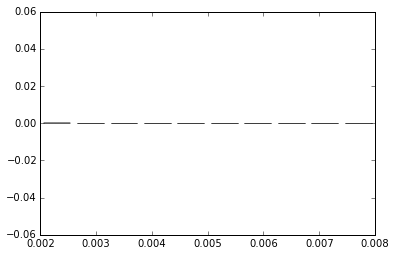

In [28]:
#np.savetxt('P.txt', P)
#P_two.shape
print P
plt.hist(P,range=(0.002,0.008))
plt.show()

#np.save('adj_socialtfidf_jaccard_jaccardvit_pearson', P)

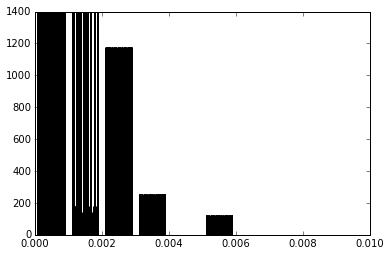

In [33]:
plt.hist(P_two,range=(0, 0.01))
plt.show()

In [30]:
# changing number of clusters
ari, ami, silh =[], [], []


numcl = 25
delta=0
#for delta in np.arange(0.01, 1, 0.02):

ari, ami, silh = eval_cluster(trues, P, delta, 'amg', numcl, 'discretize', ari, ami, silh, 'socialtfidf')

#ari, ami, silh = eval_cluster(inters, gt, P_three, delta, 'arpack', numcl, 'discretize', ari, ami, silh, 'socialtfidf')
print ari, ami, silh

/home/soyeon1771/anaconda2/lib/python2.7/site-packages/sklearn/manifold/spectral_embedding_.py:265: UserWarning: AMG works better for sparse matrices
  warnings.warn("AMG works better for sparse matrices")
/home/soyeon1771/anaconda2/lib/python2.7/site-packages/pyamg/aggregation/aggregation.py:214: SparseEfficiencyWarning: Implicit conversion of A to CSR
  SparseEfficiencyWarning)


[0.0002716600571337428] [0.00083601087514084899] [-7.8229779e-05]


average(jaccard):  0.454599998671
maximum at delta:  0.69 , score:  0.486951730307


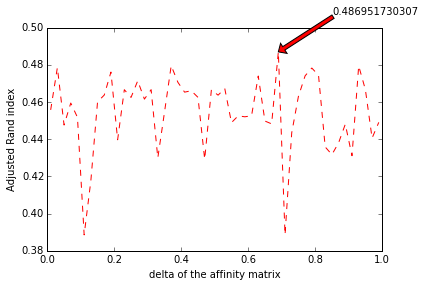

average(jaccard):  0.607754426266
maximum at delta:  0.93 , score:  0.637655794867


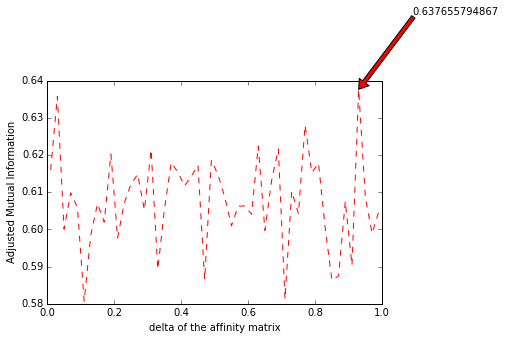

average(jaccard):  -0.000219930149615
maximum at delta:  0.11 , score:  -0.000162549


ValueError: width and height must each be below 32768

In [24]:
x = np.arange(0.01, 1, 0.02)
xlabel = 'delta of the affinity matrix'

showplot(x, xlabel, 'Adjusted Rand index', ari)
showplot(x, xlabel, 'Adjusted Mutual Information', ami)
showplot(x, xlabel, 'Silhouette Coefficient', silh)

In [57]:
#np.savetxt('adj_socialtfidf_jaccard.txt', adj_socialtfidf_jaccard)
np.savetxt('adj_socialtfidf_jaccard_jaccardvit.txt', P)